In [ ]:
# 從kaggle下載圖片資料集
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download ashfakyeafi/glasses-classification-dataset/ --unzip


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/ashfakyeafi/glasses-classification-dataset/versions/
License(s): Apache 2.0
  0% 0.00/1.02M [00:00<?, ?B/s]
100% 1.02M/1.02M [00:00<00:00, 49.9MB/s]


In [ ]:
#導入必要的函式庫
import tensorflow as tf
import numpy as np
import random
import time
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import PIL.Image as Image
import tensorflow_hub as hub
import os


In [ ]:
#選擇模型導入classifier
resnet_v1_50 = "https://tfhub.dev/google/imagenet/resnet_v1_50/classification/5"

IMAGE_SHAPE = (155,155)

classifier = tf.keras.Sequential([
    hub.KerasLayer(resnet_v1_50, input_shape=IMAGE_SHAPE+(3,))
])

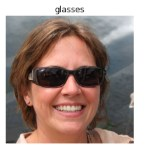

In [ ]:
sample_img_1 = Image.open(r"/content/train/glasses/row-1-column-1.jpg")
sample_img_1

In [ ]:
sample_img_1 = np.array(sample_img_1)/255.0
sample_img_1.shape

(155, 159, 3)

In [ ]:
#建立訓練集與驗證集
batch_size = 32
img_height = 155
img_width = 155

train_ds = tf.keras.utils.image_dataset_from_directory(
  str('/content/train'),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str('/content/validate'),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 104 files belonging to 2 classes.
Using 84 files for training.
Found 40 files belonging to 2 classes.
Using 8 files for validation.


In [ ]:
class_names = np.array(train_ds.class_names)
print(class_names)

['glasses' 'noglasses']


In [ ]:
#正規化
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [ ]:
#自動調諧
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 155, 155, 3)
(32,)


In [ ]:
result_batch = classifier.predict(train_ds)

3/3 [==============================] - 1s 166ms/step


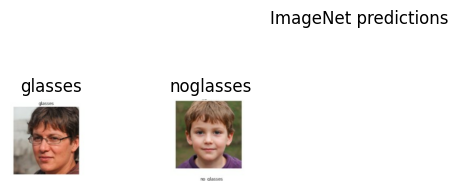

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(2):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [ ]:
#建立Model
num_classes = len(class_names)

model = tf.keras.Sequential([
  classifier,
  tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 1001)              25612201  
                                                                 
 dense_3 (Dense)             (None, 2)                 2004      
                                                                 
Total params: 25614205 (97.71 MB)
Trainable params: 2004 (7.83 KB)
Non-trainable params: 25612201 (97.70 MB)
_________________________________________________________________


In [ ]:
predictions = model(image_batch)

In [ ]:
predictions.shape

TensorShape([32, 2])

In [ ]:
#訓練紀錄
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [ ]:
#訓練
NUM_EPOCHS = 20

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3/3 [==============================] - 14s 5s/step - loss: 0.9359 - acc: 0.5952 - val_loss: 0.3216 - val_acc: 0.8750
Epoch 2/20
3/3 [==============================] - 8s 4s/step - loss: 0.6728 - acc: 0.6190 - val_loss: 0.2504 - val_acc: 0.8750
Epoch 3/20
3/3 [==============================] - 7s 4s/step - loss: 0.4750 - acc: 0.7976 - val_loss: 0.3026 - val_acc: 0.8750
Epoch 4/20
3/3 [==============================] - 8s 4s/step - loss: 0.3876 - acc: 0.8095 - val_loss: 0.2193 - val_acc: 0.8750
Epoch 5/20
3/3 [==============================] - 7s 3s/step - loss: 0.3046 - acc: 0.8571 - val_loss: 0.1820 - val_acc: 1.0000
Epoch 6/20
3/3 [==============================] - 9s 4s/step - loss: 0.2495 - acc: 0.8810 - val_loss: 0.1986 - val_acc: 1.0000
Epoch 7/20
3/3 [==============================] - 7s 4s/step - loss: 0.2049 - acc: 0.9286 - val_loss: 0.1829 - val_acc: 1.0000
Epoch 8/20
3/3 [==============================] - 9s 4s/step - loss: 0.1702 - acc: 0.9762 - val_loss: 0.1560 - val_acc: 1

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 1s 765ms/step
['glasses' 'noglasses' 'glasses' 'noglasses' 'glasses' 'glasses'
 'noglasses' 'glasses' 'glasses' 'noglasses' 'noglasses' 'glasses'
 'noglasses' 'glasses' 'glasses' 'glasses' 'glasses' 'noglasses' 'glasses'
 'noglasses' 'glasses' 'glasses' 'glasses' 'glasses' 'glasses' 'glasses'
 'glasses' 'noglasses' 'glasses' 'noglasses' 'noglasses' 'noglasses']


In [ ]:
#————save to google drive————
import os
from google.colab import drive
MOUNTPOINT = "/content/gdrive"

DATADIR = os.path.join(MOUNTPOINT, "MyDrive/TF_Models")
saved_model_path = os.path.join(DATADIR,"glasses-classification-dataset")
model.save(saved_model_path)

In [ ]:
#————Load the model from google drive ————
import os
from google.colab import drive
MOUNTPOINT = "/content/gdrive"

DATADIR = os.path.join(MOUNTPOINT, "MyDrive/TF_Models")
saved_model_path = os.path.join(DATADIR,"glasses-classification-dataset")

In [ ]:
saved_model_path

'/content/gdrive/MyDrive/TF_Models/glasses-classification-dataset'

In [ ]:
import tensorflow as tf
import numpy as np
import PIL.Image as Image
import matplotlib.pylab as plt

IMAGE_SHAPE = (155, 155)

classifier = tf.keras.models.load_model(saved_model_path)

In [ ]:
sample_img_1 = Image.open(r"/content/test/row-7-column-1.jpg")
sample_img_1 = sample_img_1.resize((155, 155))

In [ ]:
sample_img_1 = np.array(sample_img_1)/255.0
sample_img_1.shape

(155, 155, 3)

In [ ]:
result = classifier.predict(sample_img_1[np.newaxis, ...])
result.shape

1/1 [==============================] - 0s 79ms/step


(1, 2)

In [ ]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=1>

In [ ]:
print(class_names)

['glasses' 'noglasses']


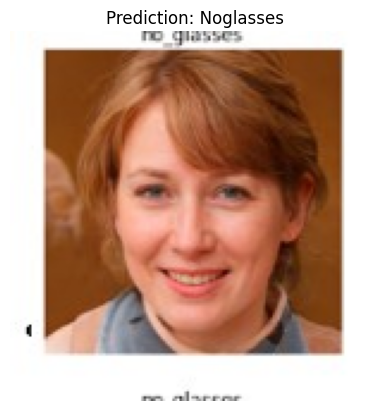

In [ ]:
plt.imshow(sample_img_1)
plt.axis('off')
predicted_class_name = class_names[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())